In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm, trange
from einops import rearrange

import sys, os
sys.path.append("../") # important for relative imports to work

In [2]:
from utils.datamodule import CIFAR10Datamodule, MNISTDatamodule
from models.unet import BaseUNet
train_dm = MNISTDatamodule("data",batch_size=32, train = True)
val_dm = MNISTDatamodule("data",batch_size=32, train = False)

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Typical image shape: torch.Size([3, 32, 32])


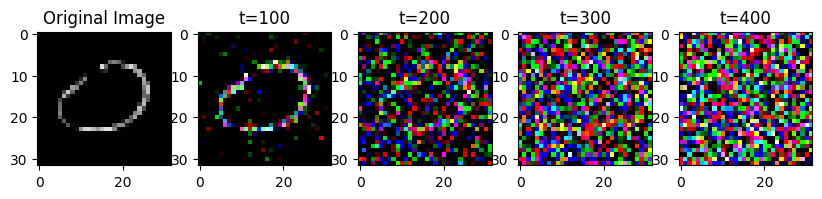

In [14]:
FORWARD_STEPS = 400
from train.beta_schedules import *

def expand_dims(x):
    """
    If x is shape (batch_size), expand it to (batch_size, 1, 1, 1)
    """
    assert len(x.shape) == 1, f"Expected shape (batch_size), got {x.shape}"
    return x[:, None, None, None]

def get_arrs(beta_schedule, device = None):
    betas = beta_schedule(FORWARD_STEPS)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim = 0)
    alphas_cumprod_prev = torch.cat([torch.tensor([1.]), alphas_cumprod[:-1]]) # Shift one to the left

    variances = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    if device is not None:
        betas = betas.to(device)
        alphas = alphas.to(device)
        alphas_cumprod = alphas_cumprod.to(device)
        sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
        sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

    # Expand dims to (batch_size, 1, 1, 1) for broadcasting (easy mult w/ images)
    betas = expand_dims(betas)
    alphas = expand_dims(alphas)
    alphas_cumprod = expand_dims(alphas_cumprod)
    sqrt_alphas_cumprod = expand_dims(sqrt_alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = expand_dims(sqrt_one_minus_alphas_cumprod)
    variances = expand_dims(variances)
    
    return betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, variances

betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, variances = get_arrs(linear_beta_schedule, device)

typical_image_shape = next(iter(train_dm.dataloader))[0][:1].shape
print("Typical image shape:", typical_image_shape[1:])

def forward_diffuse(x_0, t):
    """
    Perform the forward diffusion process, as per the one-step formulation in the DDPM paper.
    Args:
        - x_0: input image. Shape: (batch_size, channel, height, width)
        - t: time step. Shape: (batch_size)
    Returns:
        - x_t: the image at time step t. Shape: (batch_size, channel, height, width)
        - noise: the generated noise. Shape: (batch_size, channel, height, width)
    """
    assert len(x_0.shape) == 4, "Input image must have shape (batch_size, channel, height, width)"
    batch_size, channel, height, width = x_0.shape
    assert (t < FORWARD_STEPS).all() and (t >= 0).all()
    assert t.shape == (batch_size,)
    noise = torch.randn(x_0.shape, device = x_0.device)
    x_t = x_0 * sqrt_alphas_cumprod[t] + noise * sqrt_one_minus_alphas_cumprod[t]
    return x_t, noise

def timestep_to_tensor(t, device = device):
    # Convert integer timestep to a tensor.
    return torch.ones(1, device = device, dtype = torch.int) * t

im = next(iter(train_dm.dataloader))[0][:1].to(device)
assert im.shape == typical_image_shape, "Incorrect image shape."

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
ax[0].imshow(im[0].permute(1, 2, 0).cpu())
ax[0].set_title("Original Image")
for i in range(1, 5):
    im, _ = forward_diffuse(im, timestep_to_tensor(i*(FORWARD_STEPS//4) - 1))
    ax[i].imshow(im[0].permute(1, 2, 0).cpu())
    ax[i].set_title(f"t={i*(FORWARD_STEPS//4)}")

In [5]:
from models.unet import KarrasUNet
import numpy as np
model = KarrasUNet(dim = 32).to(device)

# Multi GPU training
# model = nn.DataParallel(model, device_ids=[2, 3])
epsilon_theta = model(im, timestep_to_tensor(0))
assert epsilon_theta.shape == im.shape

In [6]:
# DDPM Sampling process
def DDPM_denoising_step(x_t, t):
    """
    Denoising process. Note: The model predicts epsilon_theta, the additive noise between x_0 and x_t.
    x_t: (batch, channel, height, width)
    t: (batch)
    """
    with torch.no_grad():
        batch_size, channels, height, width = x_t.shape
        epsilon_theta = model(x_t, t)
        ratio = (1 - alphas[t]) / sqrt_one_minus_alphas_cumprod[t]

        # Shape: (B, 1, 1, 1)
        std_t = variances[t].sqrt()
        # Only add noise if t != 0
        z = torch.randn(x_t.shape, device = epsilon_theta.device) * (t > 0) # binary mask    
        x_t_minus_1 = ((x_t - ratio * epsilon_theta) / alphas[t].sqrt()) + std_t * z

        assert std_t.shape == (batch_size, 1, 1, 1)
        assert z.shape == x_t.shape
        assert t.shape == (batch_size,)
        return x_t_minus_1
    
def show_tensor(x, normalization_mean = (0.5, 0.5, 0.5), normalization_std = (0.5, 0.5, 0.5)):
    inverse_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.permute(1, 2, 0)),
        # Undo normalization
        transforms.Lambda(lambda x: x * torch.tensor(normalization_std, device = x.device) + torch.tensor(normalization_mean, device = x.device)),
        transforms.Lambda(lambda x: x * 255.0), # Convert to 0-255
        transforms.Lambda(lambda x: x.cpu().numpy().astype(np.uint8)),
    ])
    return inverse_transforms(x)

# Visualize
def visualize_DDPM_denoising():
    fig, ax = plt.subplots(1, 11, figsize=(15, 5))
    im = torch.randn(typical_image_shape, device = device) # Noise sampled from N(0, I)
    ax[0].imshow(show_tensor(im[0]))
    ax[0].set_title("t="+str(FORWARD_STEPS))
    for step in reversed(trange(0, FORWARD_STEPS)):
        im = DDPM_denoising_step(im, torch.ones(1, device = device, dtype=torch.int) * step)
        if step % (FORWARD_STEPS//10) == 0:
            ax[10 - step // (FORWARD_STEPS//10)].imshow(show_tensor(im[0]))
            ax[10 - step // (FORWARD_STEPS//10)].set_title(f"t={step}")

    ax[-1].imshow(show_tensor(im[0]))
    plt.title("Denoised Image")
    plt.show()

  0%|          | 0/400 [00:00<?, ?it/s]

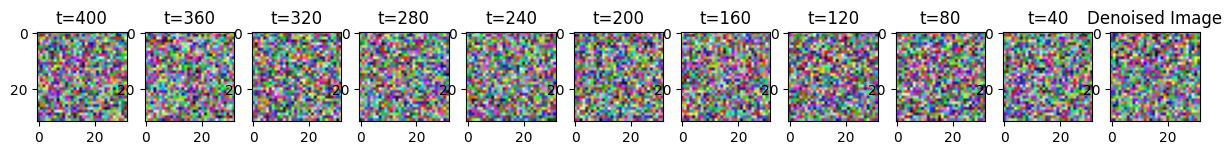

  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
# Main Training Loop
NUM_EPOCHS = 5

from torch import optim
optimizer = optim.Adam(model.parameters(), lr=5e-4)

loss_ema = None
for epoch in range(NUM_EPOCHS):
    visualize_DDPM_denoising()
    with tqdm(train_dm.dataloader) as pbar:
        for x, class_label in pbar:
            x = x.to(device); class_label = class_label.to(device)
            # TODO: Condition on class label
            t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device) # batch of t
            x_t, noise = forward_diffuse(x, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, noise) # TODO: Experiment with l1 loss
            loss.backward()
            loss_ema = round(loss_ema * 0.95 + loss.item() * 0.05 if loss_ema else loss.item(), 3)
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_postfix({"Training loss": loss_ema})

    validation_loss = []
    with torch.no_grad():
        with tqdm(val_dm.dataloader) as pbar:
            for x, class_label in pbar:
                x = x.to(device); class_label = class_label.to(device)
                t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device)
                x_t, noise = forward_diffuse(x, t)
                epsilon_theta = model(x_t, t)
                loss = F.mse_loss(epsilon_theta, noise)
                validation_loss.append(loss.item())
    mean_val_loss = sum(validation_loss) / len(validation_loss)
    print(f"Epoch {epoch}. Validation loss: {mean_val_loss:.3f}")
visualize_DDPM_denoising()

In [8]:
im = torch.randn(typical_image_shape, device = device) * alphas_cumprod[0].sqrt()
for step in reversed(trange(0, FORWARD_STEPS)):
    im = DDPM_denoising_step(im, torch.ones(1, device = device, dtype=torch.int) * step)

  0%|          | 0/400 [00:00<?, ?it/s]

In [12]:
show_tensor(im[0])

array([[[100,   8, 123],
        [195, 127, 189],
        [243, 168,  48],
        ...,
        [ 23, 152,  22],
        [ 48,  21, 223],
        [195,  89,  16]],

       [[205,   3,  80],
        [115, 232,  32],
        [ 54, 197, 192],
        ...,
        [246, 142,  89],
        [220, 229, 159],
        [130,   9, 120]],

       [[239, 188, 193],
        [ 19,  13,  26],
        [202, 215,  20],
        ...,
        [ 53, 167, 118],
        [160, 146,  40],
        [228, 134,  54]],

       ...,

       [[ 53,  58, 138],
        [ 53,  17, 122],
        [242,   2,  13],
        ...,
        [156,  42, 217],
        [ 27,  48, 243],
        [123, 221, 255]],

       [[209, 138, 137],
        [  5,   3, 111],
        [223,  53, 158],
        ...,
        [ 31,  56, 233],
        [177, 141,  95],
        [251, 198,  48]],

       [[ 39,   7,  27],
        [158, 140, 153],
        [ 99, 194, 240],
        ...,
        [ 46,  26, 240],
        [126, 198, 108],
        [114, 184,  36]]

In [32]:
validation_loss = []
with torch.no_grad():
    with tqdm(val_dm.dataloader) as pbar:
        for x, class_label in pbar:
            x = x.to(device); class_label = class_label.to(device)
            t = torch.randint(0, FORWARD_STEPS, (x.shape[0],), device = device)
            x_t, noise = forward_diffuse(x, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, x)
            validation_loss.append(loss.item())
mean_val_loss = sum(validation_loss) / len(validation_loss)
print(f"Epoch {epoch}. Validation loss: {mean_val_loss:.3f}")

  0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [29]:
x.shape, t.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

torch.Size([32, 3, 32, 32])

  0%|          | 0/199 [00:00<?, ?it/s]

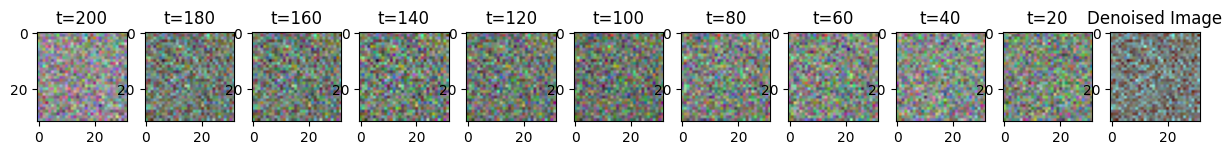

In [10]:
# Sampling process
def denoising_step(x_t, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    x: input image at timestamp t [B, C, H, W]
    t: the timestamp [B]
    """
    with torch.no_grad():
        epsilon_theta = model(x_t, torch.ones(1, device = device) * t)
        bar_alpha_t = alphas_cumprod[t]
        alpha_t = alphas[t]
        ratio = (1 - alpha_t) / torch.sqrt(1 - bar_alpha_t)

        var_t = 1 - bar_alpha_t
        z = torch.randn(x_t.shape, device = epsilon_theta.device)

        x_t_minus_1 = ((x_t - ratio * epsilon_theta) / torch.sqrt(alpha_t)) 
        if t != 0: x_t_minus_1 += torch.sqrt(var_t) * z
        return x_t_minus_1
    
# Visualize
def visualize_denoising():
    fig, ax = plt.subplots(1, 11, figsize=(15, 5))
    im = torch.randn(next(iter(train_dm.dataloader))[0].shape, device = device) * sqrt_one_minus_alphas_cumprod[0]
    to_show = im[0].permute(1, 2, 0).cpu()
    to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
    ax[0].imshow(to_show)
    ax[0].set_title("t=200")
    for step in reversed(trange(1, FORWARD_STEPS)):
        im = denoising_step(im, step)
        if step % 20 == 0:
            to_show = im[0].permute(1, 2, 0).cpu()
            # Normalize between -1 and 1
            to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
            ax[FORWARD_STEPS // 20 - step // 20].imshow(to_show)
            ax[FORWARD_STEPS // 20 - step // 20].set_title(f"t={step}")

    to_show = im[0].permute(1, 2, 0).cpu()
    to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
    ax[-1].imshow(to_show)
    plt.title("Denoised Image")
    plt.show()

visualize_denoising()